In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
# imports for supplemental Data
import holidays
import datetime as dt
from holidays import country_holidays
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)

In [2]:
csv = glob.glob('Data/Chicago/*.csv')
dfs=[pd.read_csv(file)for file in csv]
df=pd.concat(dfs,ignore_index=True)
df.head()

ID                    Date         Primary Type  Description  \
0  1313213  01/01/2001 01:00:00 AM              BATTERY       SIMPLE   
1  1315987  01/01/2001 01:00:00 AM      CRIMINAL DAMAGE  TO PROPERTY   
2  1317380  01/01/2001 01:00:00 PM      CRIMINAL DAMAGE   TO VEHICLE   
3  1319931  01/01/2001 01:00:00 PM              BATTERY       SIMPLE   
4  1312557  01/01/2001 01:00:00 PM  MOTOR VEHICLE THEFT   AUTOMOBILE   

     Location Description  Arrest  Domestic  Beat  District  Ward   Latitude  \
0  VEHICLE NON-COMMERCIAL   False      True   731       7.0   NaN  41.765396   
1           CHA APARTMENT   False     False  1823      18.0   NaN  41.899860   
2                  STREET   False     False   911       9.0   NaN  41.807498   
3               RESIDENCE   False      True   825       8.0   NaN  41.783892   
4                  STREET   False     False   513       5.0   NaN  41.695025   

   Longitude  
0 -87.626698  
1 -87.639877  
2 -87.689155  
3 -87.684841  
4 -87.620629

## Initial EDA

- Add holidays to df

In [3]:
all_days = pd.date_range(df["Date"].min(), df["Date"].max())
us_holidays = country_holidays('US')

In [4]:
df["US Holiday"] = [us_holidays.get(day) for day in df['Date']]

- drop any cols that will not be used to answer phrased questions.

In [5]:
df=df.drop(columns=['Latitude','Longitude','Ward','Location Description','ID'])

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
df = df.set_index('Date')
df.head()

Primary Type  Description  Arrest  Domestic  Beat  \
Date                                                                            
2001-01-01 01:00:00              BATTERY       SIMPLE   False      True   731   
2001-01-01 01:00:00      CRIMINAL DAMAGE  TO PROPERTY   False     False  1823   
2001-01-01 13:00:00      CRIMINAL DAMAGE   TO VEHICLE   False     False   911   
2001-01-01 13:00:00              BATTERY       SIMPLE   False      True   825   
2001-01-01 13:00:00  MOTOR VEHICLE THEFT   AUTOMOBILE   False     False   513   

                     District      US Holiday  
Date                                           
2001-01-01 01:00:00       7.0  New Year's Day  
2001-01-01 01:00:00      18.0  New Year's Day  
2001-01-01 13:00:00       9.0  New Year's Day  
2001-01-01 13:00:00       8.0  New Year's Day  
2001-01-01 13:00:00       5.0  New Year's Day

In [7]:
crime_counts = df['Primary Type'].value_counts().to_frame('# of Crimes')

- binning times for later processing

In [8]:
df['Year']  = df.index.year
df['Month'] = df.index.month
df['HourOfDay'] = df.index.hour 
df.head()

Primary Type  Description  Arrest  Domestic  Beat  \
Date                                                                            
2001-01-01 01:00:00              BATTERY       SIMPLE   False      True   731   
2001-01-01 01:00:00      CRIMINAL DAMAGE  TO PROPERTY   False     False  1823   
2001-01-01 13:00:00      CRIMINAL DAMAGE   TO VEHICLE   False     False   911   
2001-01-01 13:00:00              BATTERY       SIMPLE   False      True   825   
2001-01-01 13:00:00  MOTOR VEHICLE THEFT   AUTOMOBILE   False     False   513   

                     District      US Holiday  Year  Month  HourOfDay  
Date                                                                   
2001-01-01 01:00:00       7.0  New Year's Day  2001      1          1  
2001-01-01 01:00:00      18.0  New Year's Day  2001      1          1  
2001-01-01 13:00:00       9.0  New Year's Day  2001      1         13  
2001-01-01 13:00:00       8.0  New Year's Day  2001      1         13  
2001-01-01 13:00:00       5.0  New Year's Day  2001      1         13

## Q1 

- Topic 1) Comparing Police Districts:
    - Which district has the most crimes? Which has the least?


In [9]:
dist= df.groupby('District')['Primary Type'].value_counts().sort_index()
plot_dist=dist.to_frame('# of crimes').reset_index()

In [10]:
dist= df.groupby('District')['Primary Type'].value_counts().sort_index()
plot_dist=dist.to_frame('# of crimes').reset_index()
combined=plot_dist.groupby('District').agg({'# of crimes':'sum'}).reset_index()

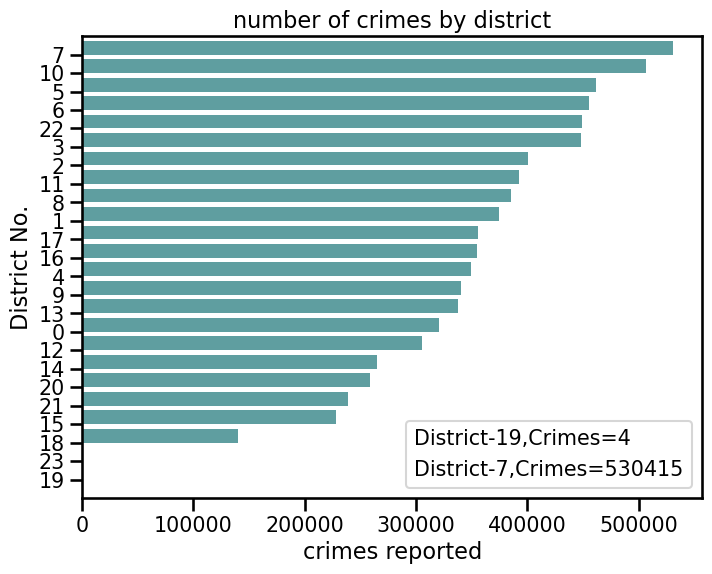

In [11]:
# identify numeric max's for plot legend 
max_id=combined['# of crimes'].idxmax()
max_value=combined['# of crimes'].max()
# identify numeric mins for plot legend
min_id=combined['# of crimes'].idxmin()
min_value=combined['# of crimes'].min()

# set labels f strings for legend
labels=[f'District-{min_id},Crimes={min_value}',f'District-{max_id},Crimes={max_value}']

# plot results
ax=combined.sort_values(by='# of crimes').plot(kind='barh',width=1.5, color='cadetblue' ,figsize=(8,6))
ax.set(title='number of crimes by district', xlabel='crimes reported', ylabel= 'District No.')
ax.legend(labels,handlelength=0, handletextpad=0);

## A: 
- district 7 has the most reported crimes weighing in with a total of 53,0415 crimes.
- District 19 has the least amount of reported crimes with a total of 4 reported crimes.

# Q2
- - Topic 4) Comparing Months:
    - What months have the most crime? What months have the least?
    - Are there any individual crimes that do not follow this pattern? If so, which crimes?

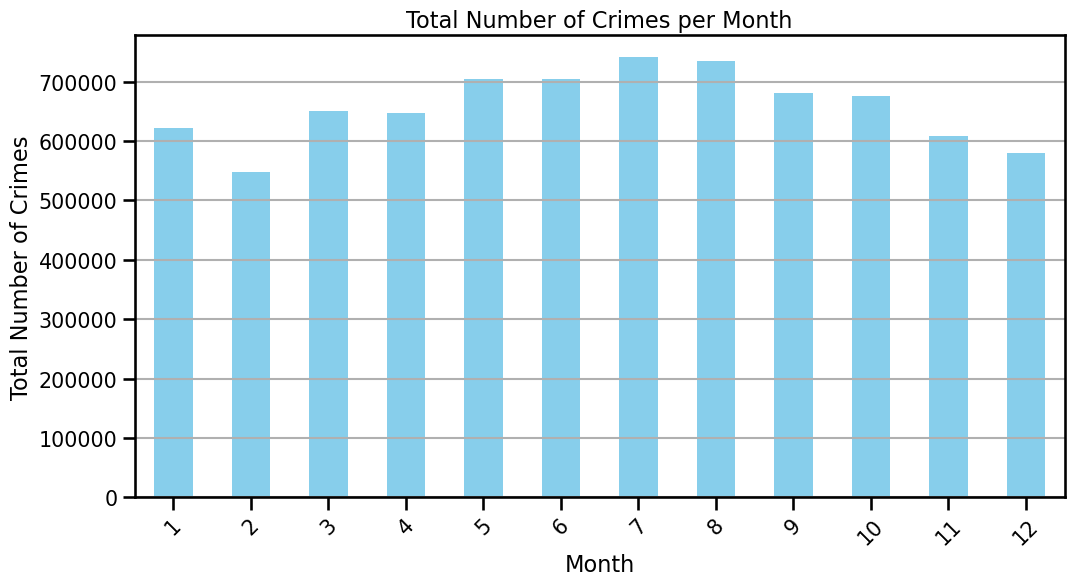

In [12]:
monthly_crime=df.groupby('Month').size()
plt.figure(figsize=(12, 6))
monthly_crime.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Number of Crimes')
plt.title('Total Number of Crimes per Month')
plt.xticks(rotation=45)
plt.grid(axis='y')

In [13]:
crime_by_month=df.groupby('Primary Type')['Month'].value_counts().sort_index()
plot_month = crime_by_month.to_frame('# of Crimes').reset_index()


c:\Users\clove\anaconda3\envs\dojo-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


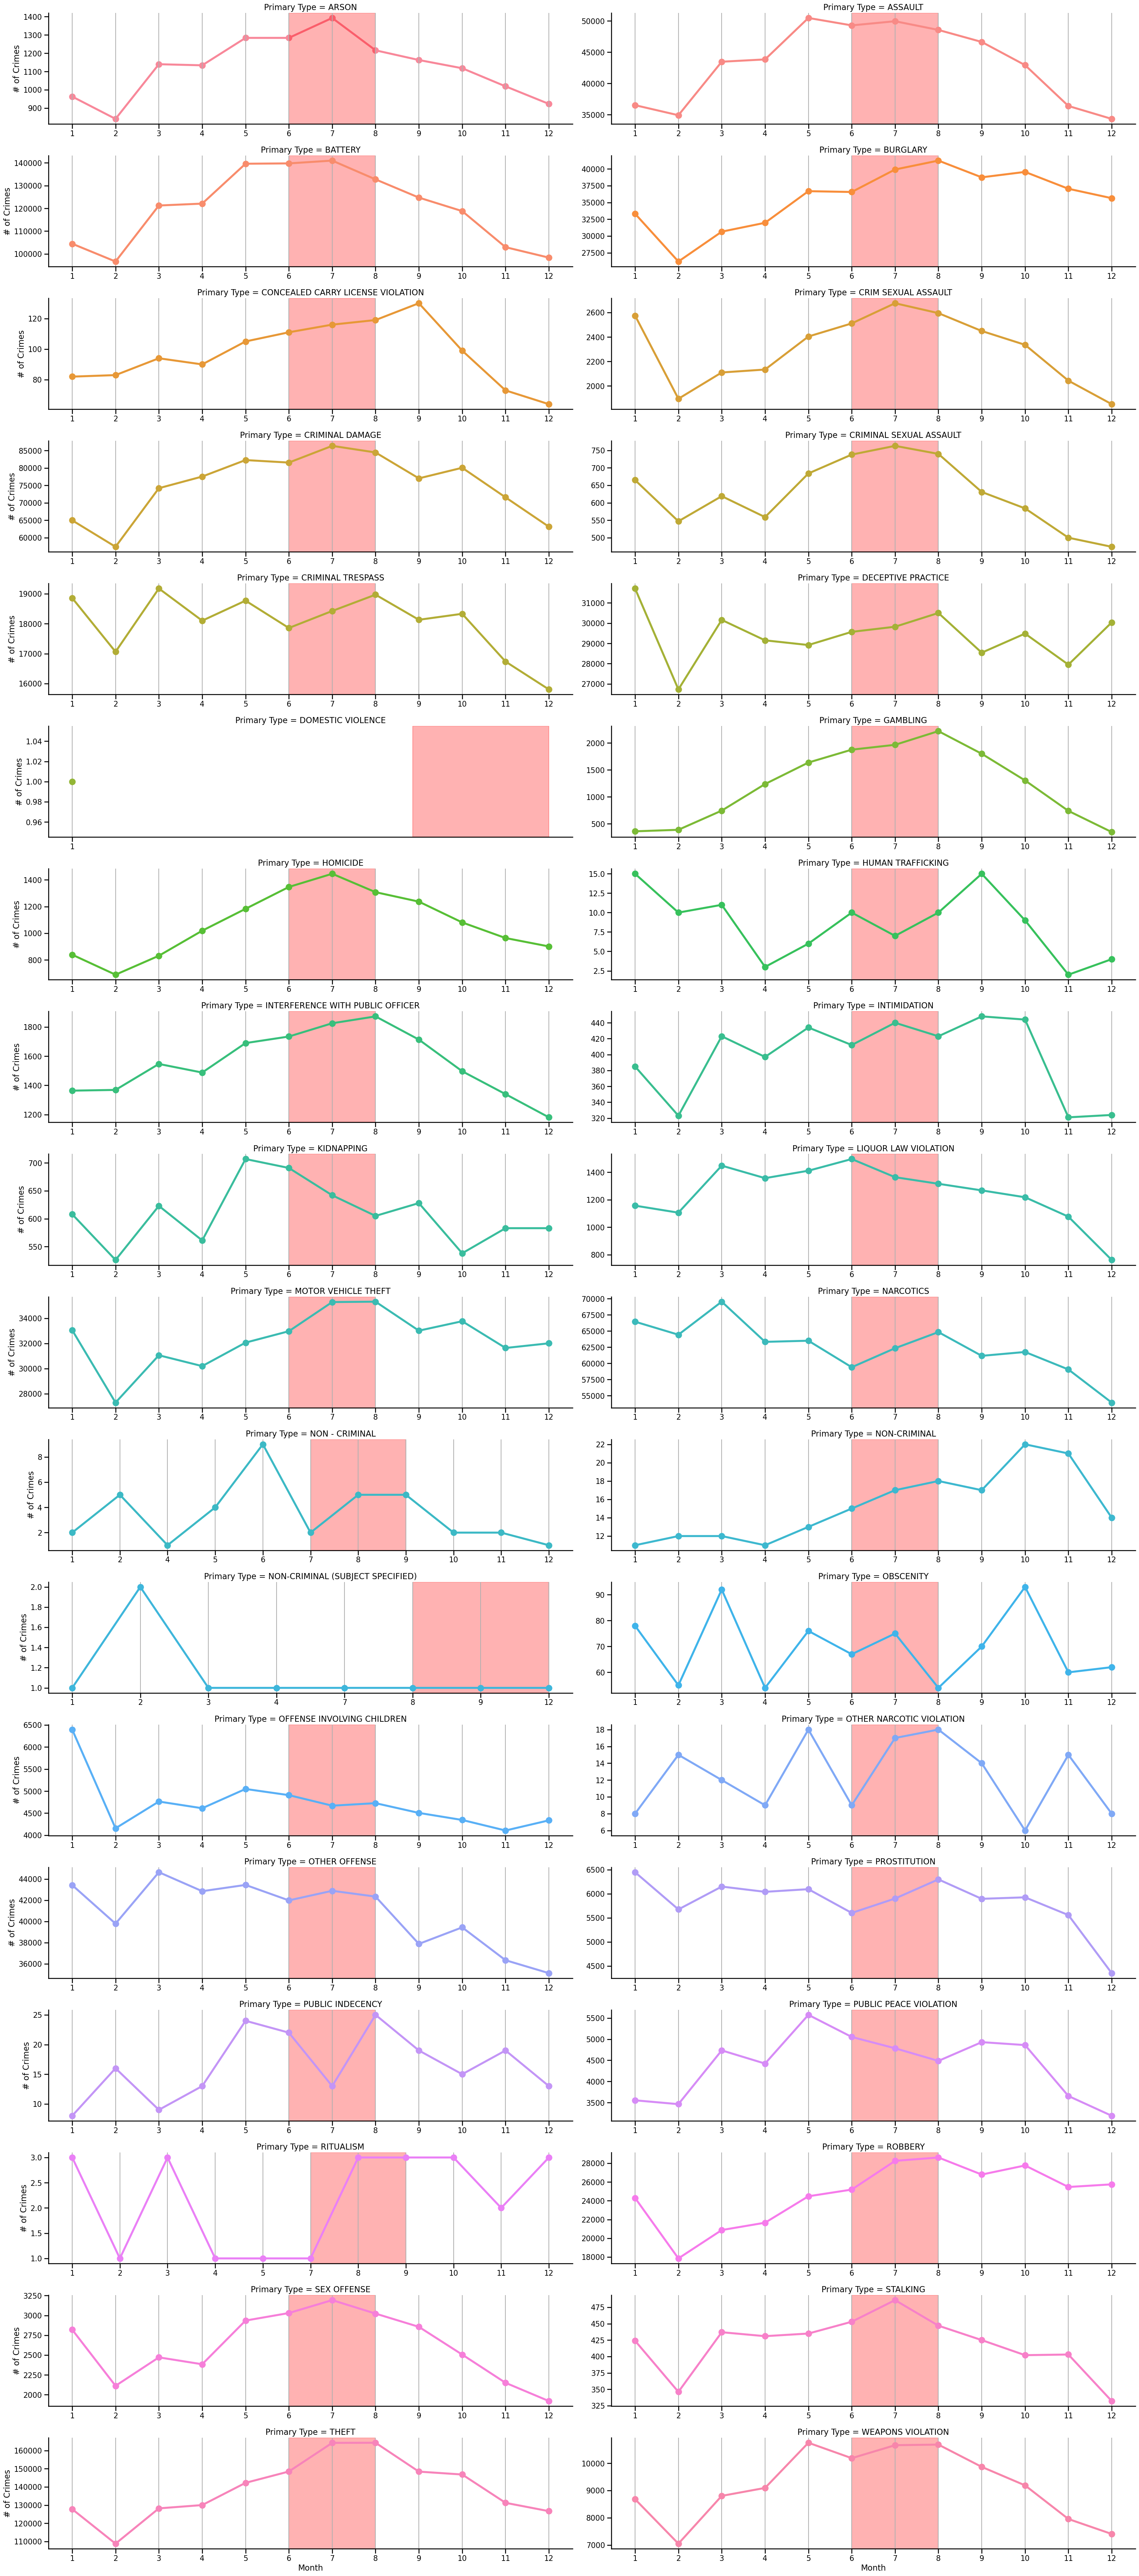

In [14]:
g = sns.catplot(data=plot_month, x='Month', y='# of Crimes',
                hue='Primary Type', col='Primary Type',col_wrap=2,
            aspect=4, height=4,
            kind='point',sharey=False,sharex=False);
for ax in g.axes:
    ax.axvspan(5, 7, color='red', alpha=0.3)
[ax.grid(axis='x') for ax in g.axes];

## A:
- the three months with he most crime are July, August, and june in that order as related in the first visual.
- Most other individual crimes tend to balance or increase with the exception of a handful(kidnapping,humantrafficking,liquor law violation,offensive involving children, and public peace violaiton )which all decrease during this "peak crimetime".

# Q3
- Topic 2) Crimes Across the Years:
- Is the total number of crimes increasing or decreasing across the years?
- Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?

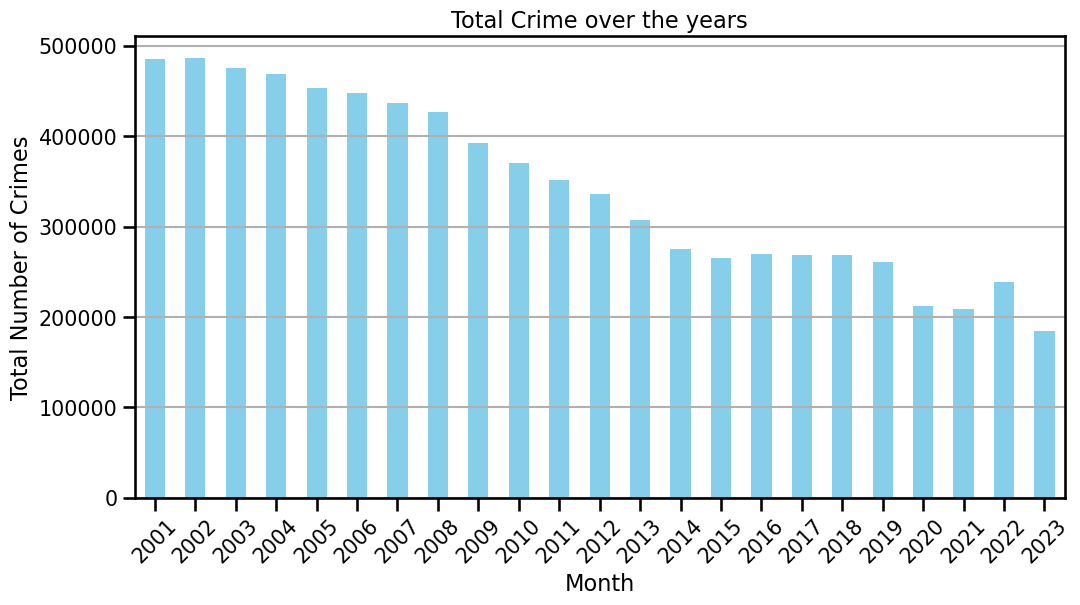

In [18]:
yearly_crime=df.groupby('Year').size()
plt.figure(figsize=(12, 6))
yearly_crime.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Number of Crimes')
plt.title('Total Crime over the years')
plt.xticks(rotation=45)
plt.grid(axis='y')

In [16]:
crime_by_year=df.groupby('Primary Type')['Year'].value_counts().sort_index()
plot_df = crime_by_year.to_frame('# of Crimes').reset_index()
plot_df=plot_df.sort_values('# of Crimes')

c:\Users\clove\anaconda3\envs\dojo-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


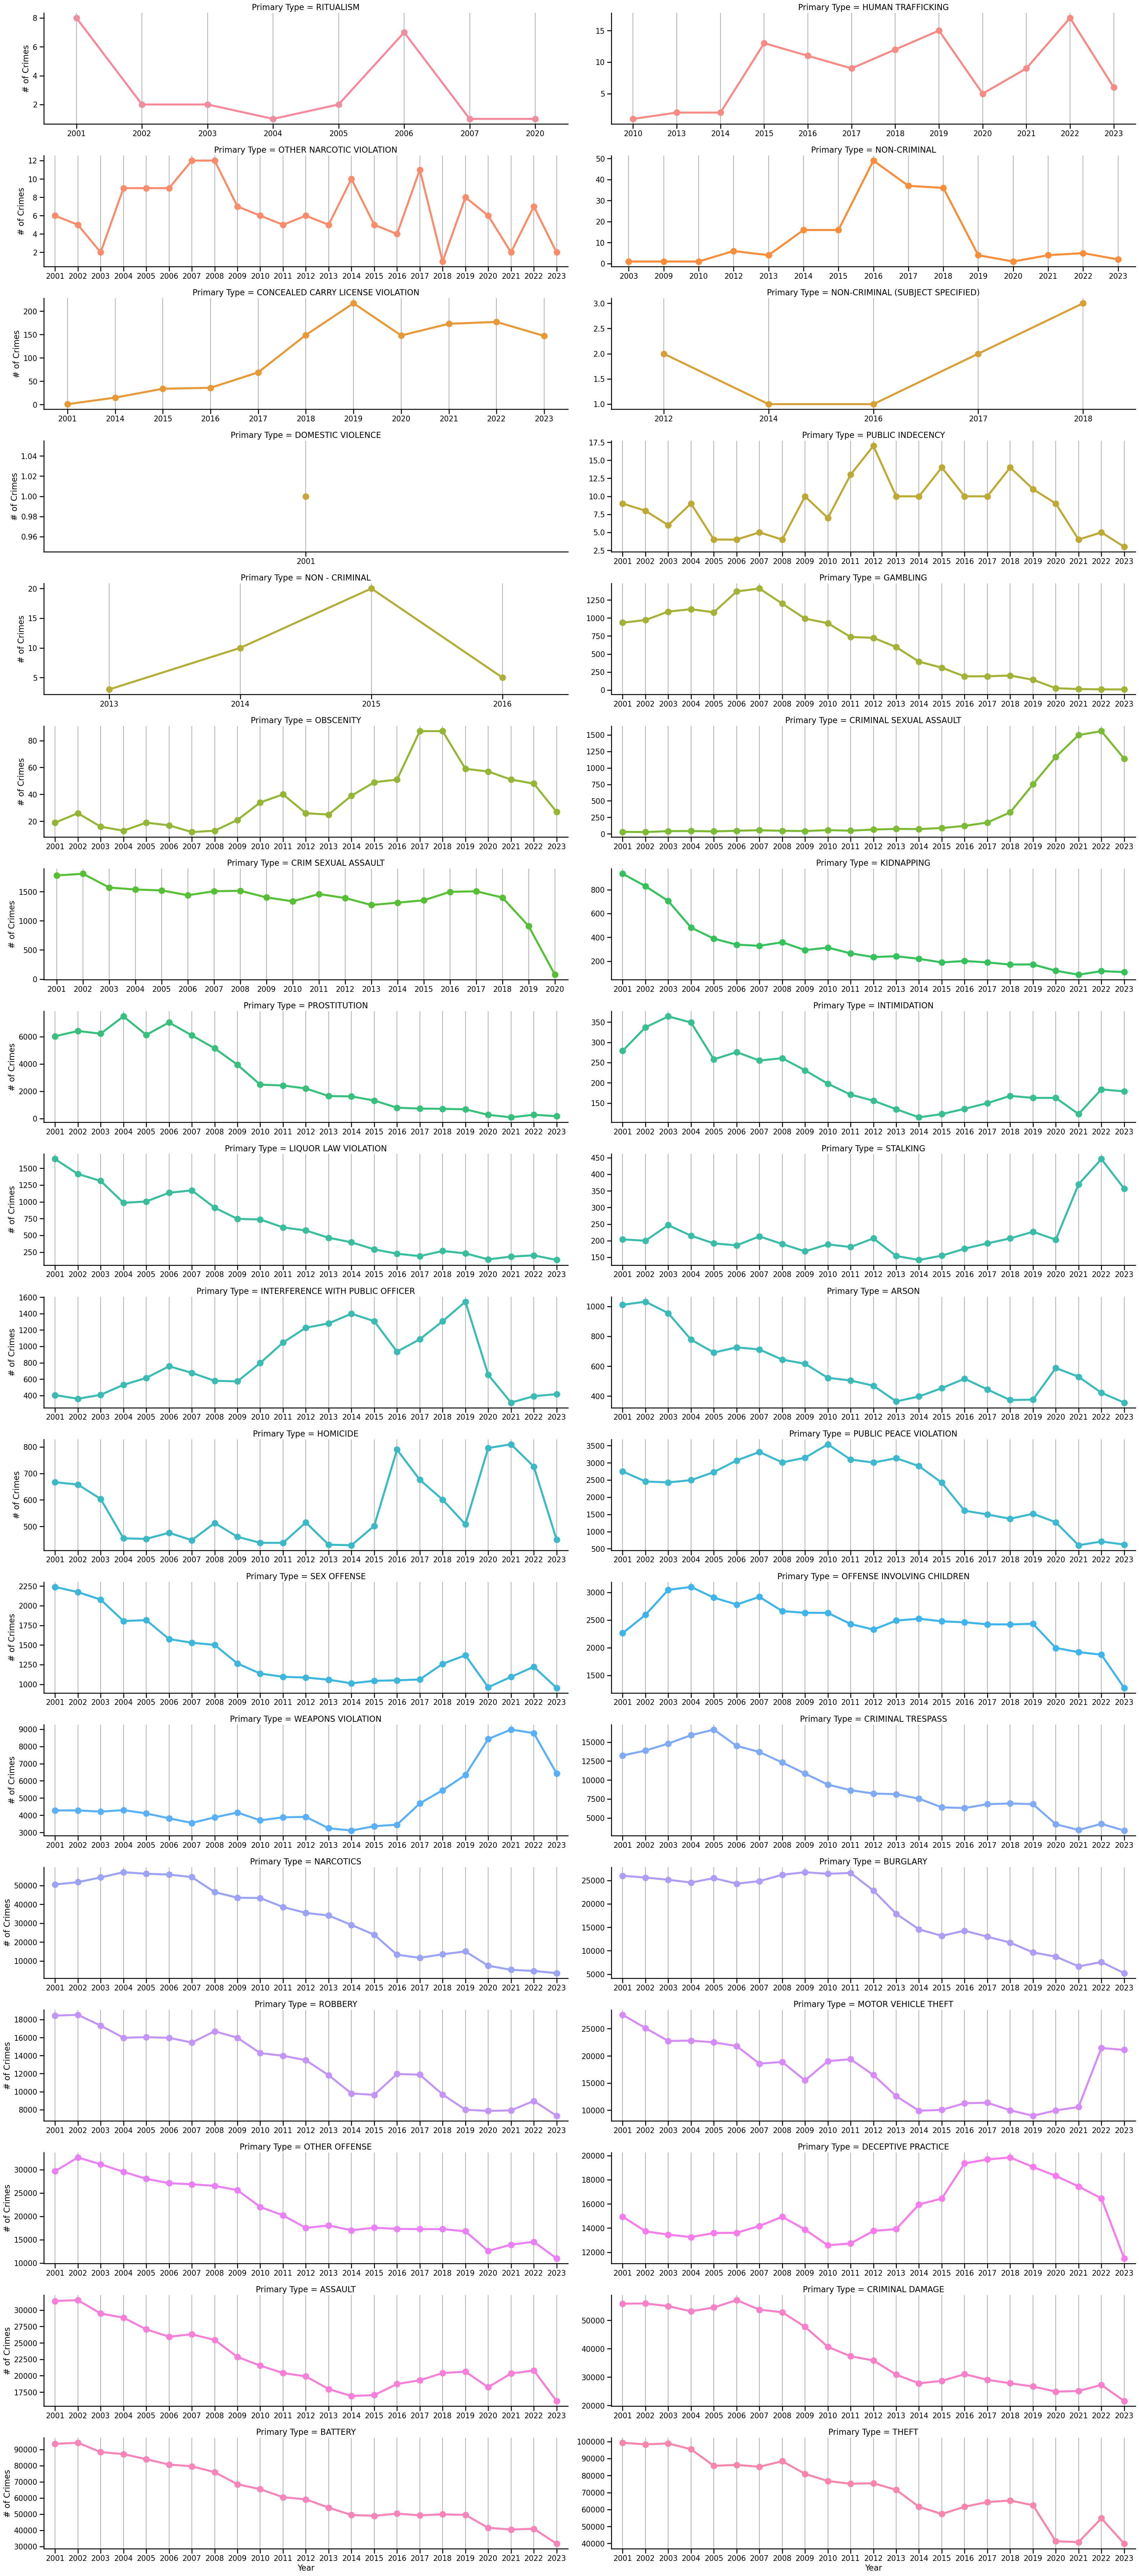

In [17]:
g = sns.catplot(data=plot_df, x='Year', y='# of Crimes',
                hue='Primary Type', col='Primary Type',col_wrap=2,
            aspect=4, height=4,
            kind='point',sharey=False,sharex=False);

[ax.grid(axis='x') for ax in g.axes];

## A:
- as related in the above plots an overal decrease in crime is apparent, while concealed carry violations,non criminal(subject specified), criminal sexual assualt, stalking, and weapons violations are on the individual rise.